# Plot Efficient Frontier and get GMV, MSR and EW portfolios

Plotting efficient frontier of the industry data

In [2]:
import pandas as pd
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import utils

In [5]:
ind = pd.read_csv("ind30_m_vw_rets.csv", header=0, index_col=0, parse_dates=True)/100

In [6]:
ind.index = pd.to_datetime(ind.index,format="%Y%m").to_period('M')

In [7]:
ind.columns = ind.columns.str.strip()

<AxesSubplot:title={'center':'Industry Sharpe Ratios 1926-2018'}>

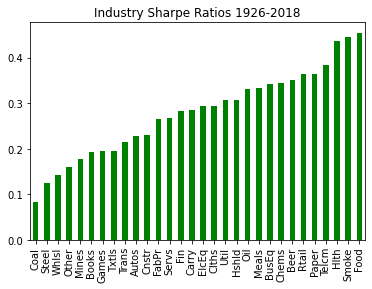

In [8]:
utils.sharpe_ratio(ind,0.03,12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2018", color="green")

<AxesSubplot:title={'center':'Industry Sharpe Ratios 2000-2018'}>

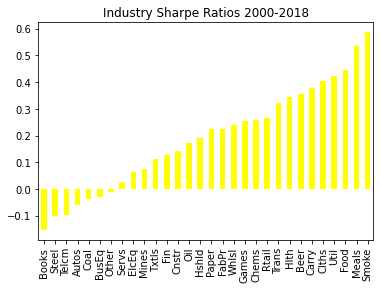

In [9]:
utils.sharpe_ratio(ind["2000":],0.03,12).sort_values().plot.bar(title="Industry Sharpe Ratios 2000-2018", color="yellow")

In [10]:
er = utils.annualize_rets(ind["1995":"2000"], 12)

<AxesSubplot:>

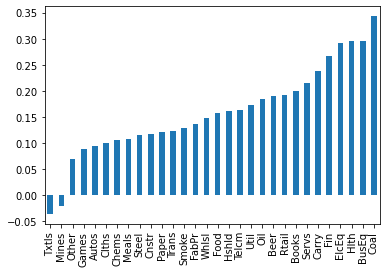

In [11]:
er.sort_values().plot.bar()

In [12]:
cov = ind["1995":"2000"].cov()

In [13]:
l = ["Food", "Beer","Smoke","Coal"]
er[l]

Food     0.157362
Beer     0.190134
Smoke    0.129288
Coal     0.343089
dtype: float64

In [14]:
cov.loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002287,0.002077,0.001757,0.000034
Beer,0.002077,0.004599,0.001143,0.001261
Smoke,0.001757,0.001143,0.007130,-0.000544
Coal,0.000034,0.001261,-0.000544,0.016153


In [15]:
weights = np.repeat(1/4,4)

In [16]:
weights

array([0.25, 0.25, 0.25, 0.25])

# 2 Assets Frontier 

In [17]:
l = ["Games","Fin"]

In [18]:
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]

<AxesSubplot:xlabel='Vol', ylabel='R'>

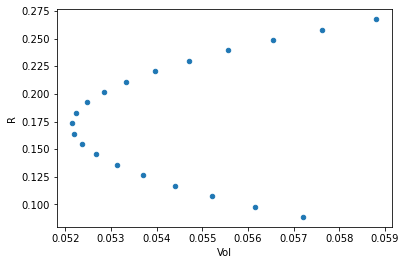

In [19]:
rets = [utils.portfolio_return(w, er[l]) for w in weights]
vols = [utils.portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({"R": rets, "Vol": vols})
ef.plot.scatter(x="Vol", y="R")

<AxesSubplot:xlabel='Volatility'>

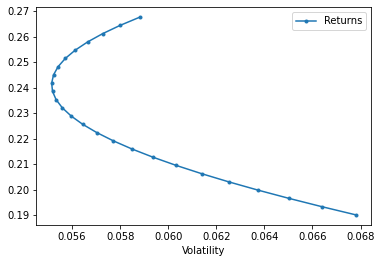

In [20]:
l = ["Fin","Beer"]
utils.plot_ef2(25, er[l], cov.loc[l,l])

# N-Asset Efficient Frontier 

In [21]:
from scipy.optimize import minimize 

In [22]:
def minimize_vol(target_return, er, cov):
    """
    target returns -> weights
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - utils.portfolio_return(weights, er)
    }
    weights_sum_to_1= {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    results = minimize(utils.portfolio_vol, init_guess, 
                       args=(cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [23]:
l = ['Games', 'Fin']

In [24]:
w15 = minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = utils.portfolio_vol(w15, cov.loc[l,l])
vol15

0.05250418123905939

In [25]:
w15

array([0.65749081, 0.34250919])

In [26]:
l = ["Smoke", "Fin", "Games", "Coal"]

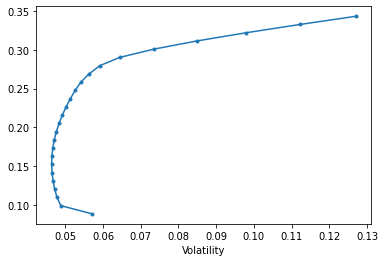

In [27]:
utils.plot_ef(25, er[l], cov.loc[l,l])

# Plotting GMV, MSR and EW portfolios on multi-asset efficient frontier 

<AxesSubplot:xlabel='Volatility'>

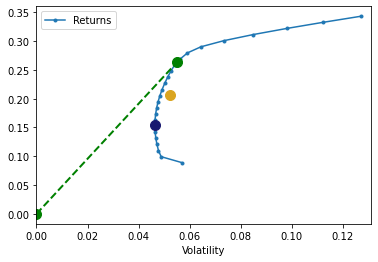

In [31]:
utils.plot_ef(25, er[l], cov.loc[l,l],legend=True, show_cml=True, riskfree_rate=0, show_ew=True, show_gmv=True)